In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

In [3]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [5]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [6]:
surp.set_yields()

In [7]:
class LinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, σ = theta
        return m * x + b
    
    def d_dx(self, x, theta):
        m, b, σ = theta
        return m + 0*x
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 1))
        p += np.log(normal(b, 0, 1))
        p += np.log(log_normal(sigma, 1, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-3, 1e-3, 1e-8]
    
    
    
    

In [9]:
df = subgiants
filt = ~df["high_alpha"]
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["N_FE_ERR"]


In [10]:
all_abundances = pd.read_csv("data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

In [11]:
import emcee
from corner import corner

In [12]:
def log_likelihood(theta, model, x_obs, y_obs, x_err, y_err):
    sigma = theta[-1]
    y_model = model(x_obs, theta)
    m = model.d_dx(x_obs, theta)
    total_variance = y_err**2 + (m**2 * x_err**2) + sigma**2
    
    ll = -0.5 * np.sum(((y_obs - y_model)**2 / total_variance) + np.log(2 * np.pi * total_variance))
    return ll


def log_probability(theta, model, *args):
    p = model.log_prior(theta)
    l = log_likelihood(theta, model, *args) 
    
    lp = l + p
    return np.where(np.isfinite(lp), lp, -np.inf)

  3%|▎         | 28/1000 [00:01<00:50, 19.19it/s]/tmp/slurmtmp.27705167/ipykernel_196738/2850301513.py:18: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1, 0.5))
  4%|▎         | 36/1000 [00:01<00:50, 19.08it/s]/tmp/slurmtmp.27705167/ipykernel_196738/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
100%|██████████| 1000/1000 [00:52<00:00, 19.18it/s]


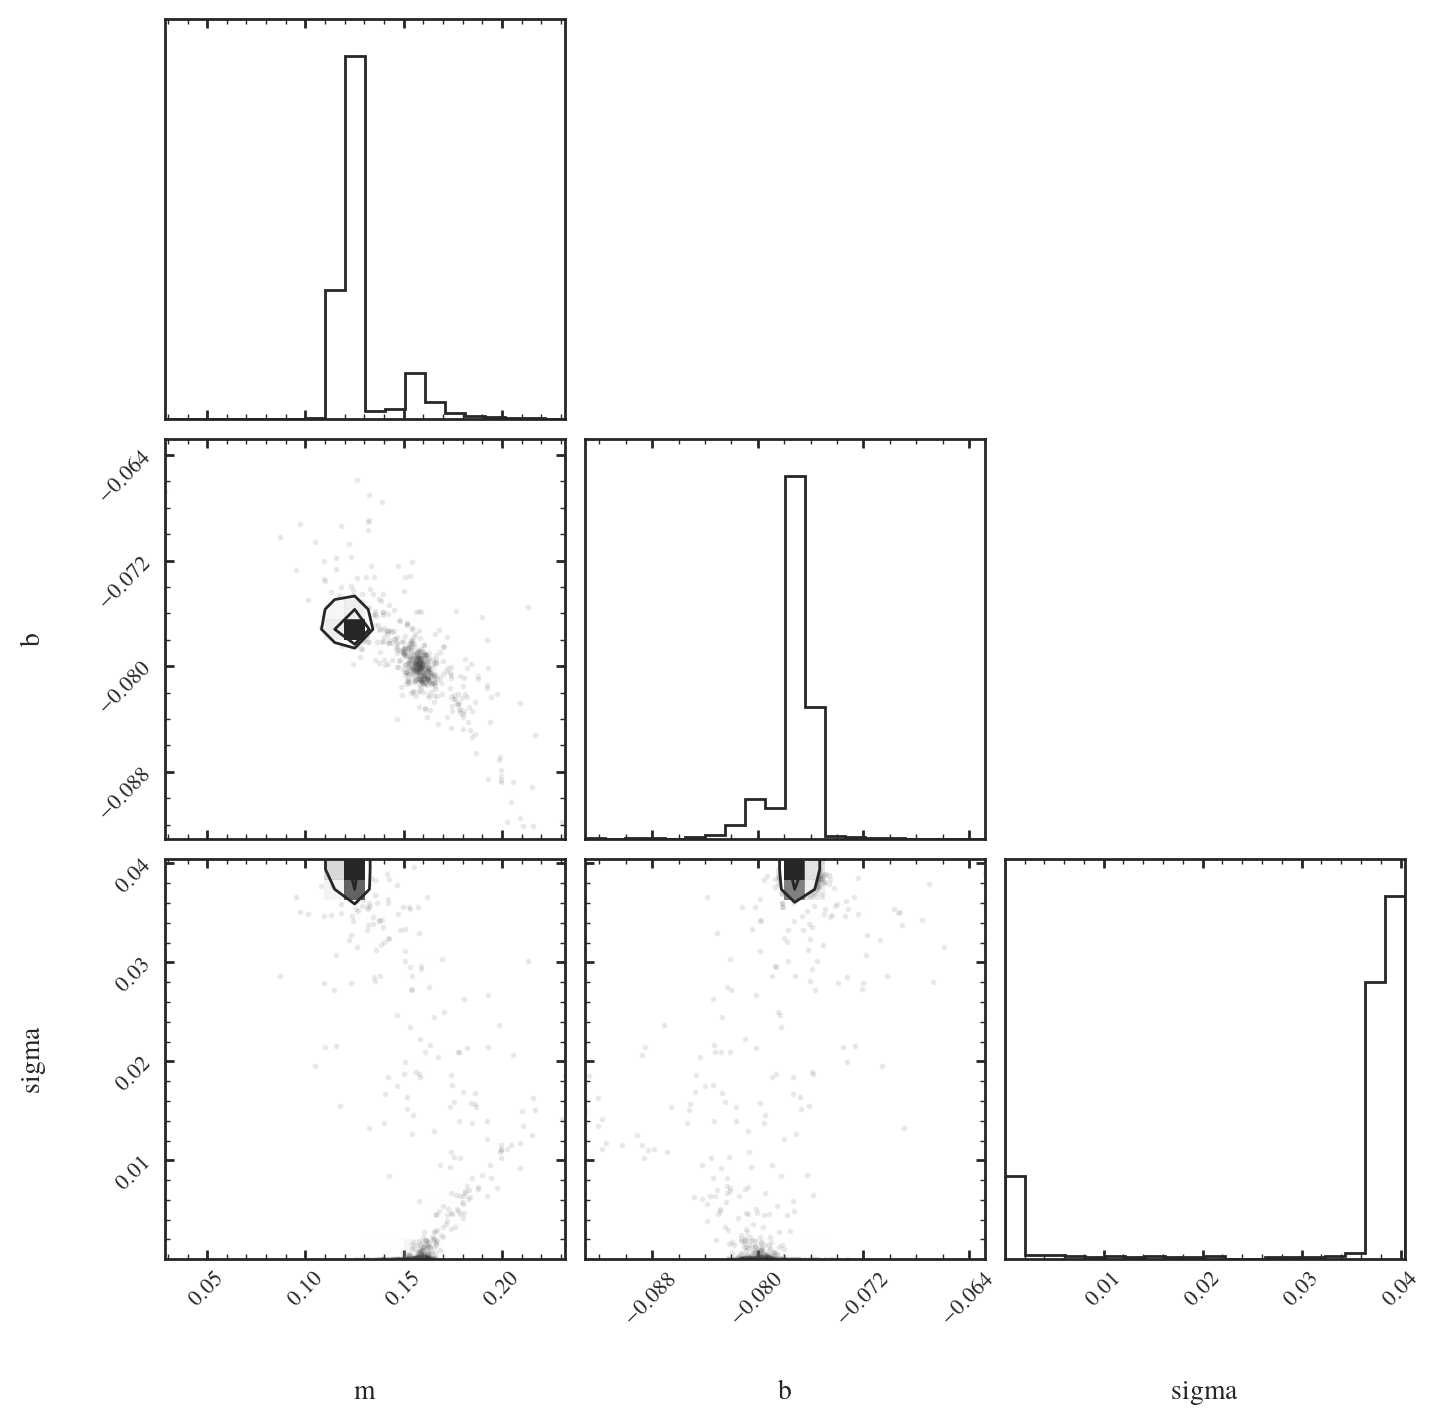

In [13]:
model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, subgiants.MG_H, subgiants.C_MG, subgiants.MG_H_ERR, subgiants.C_MG_ERR))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

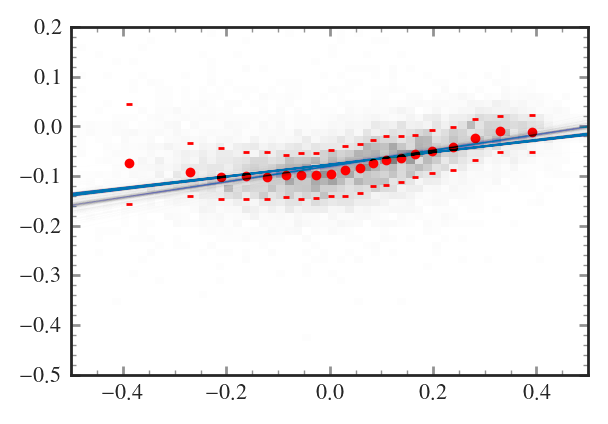

In [14]:
plt.hist2d(subgiants.MG_H, subgiants.C_MG, 200, cmap="Greys", alpha=0.5);

for i in range(0, len(samples), 1):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.02, )
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.2)
arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", color="r", errorbar="pi")


In [15]:
np.mean(samples, axis=0)

array([ 0.12791047, -0.07730219,  0.03315131])

# Exponential model

In [92]:
class ExpModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, σ = theta
        yc_mg =  m * (gcem.MH_to_Z(x) - Z_SUN) + b
        return gcem.abund_to_brak(yc_mg, "C", "mg")
    
    def d_dx(self, x, theta):
        m, b, σ = theta
        return m + 0*x
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 50))
        p += np.log(normal(b, 5, 2))
        p += np.log(log_normal(sigma, 0.03, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-3, 5, 0.03]
    
    
    
    

In [93]:
model = ExpModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-1 * np.random.randn(nwalkers, ndim))


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/slurmtmp.27705167/ipykernel_196738/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27705167/ipykernel_196738/3161002839.py:19: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 0.03, 0.5))
100%|██████████| 1000/1000 [00:03<00:00, 259.66it/s]


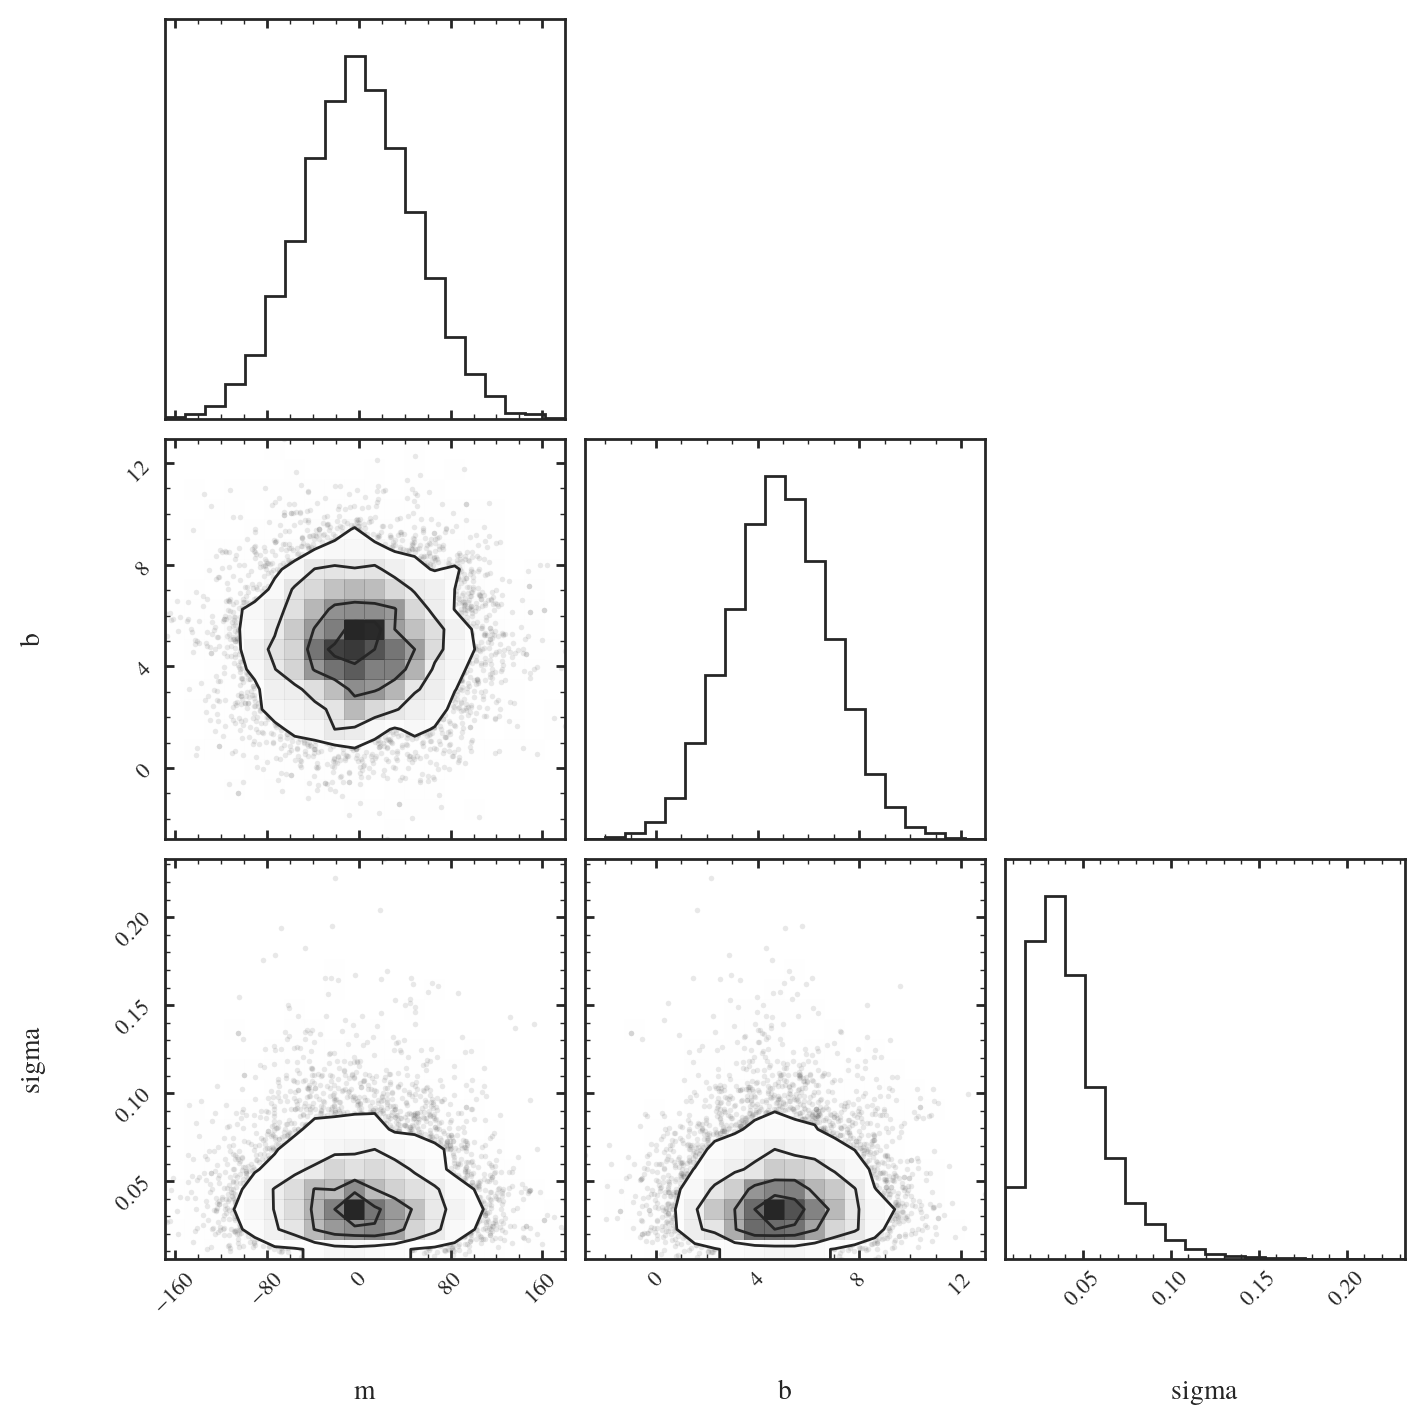

In [94]:


sp = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, np.array([]), np.array([]), np.array([]), np.array([])))
sp.run_mcmc(p0, 1000, progress=True);
samples = sp.get_chain(discard=100, thin=5, flat=True)

corner(samples, labels=["m", "b", "sigma"]);

/users/PAS2232/aeyobd/surp/surp/gce_math.py:80: RuntimeWarning: invalid value encountered in log10
  return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))


(-0.5, 0.2)

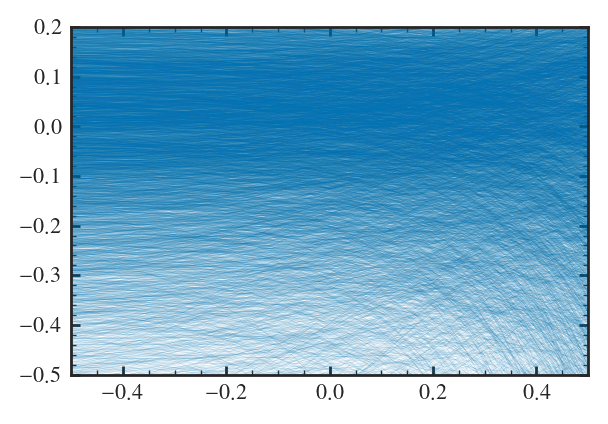

In [82]:

for i in range(0, len(samples), 1):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.2, )
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.2)


 13%|█▎        | 134/1000 [00:07<00:49, 17.64it/s]/tmp/slurmtmp.27705167/ipykernel_196738/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.27705167/ipykernel_196738/3161002839.py:19: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 0.03, 0.5))
100%|██████████| 1000/1000 [01:03<00:00, 15.71it/s]


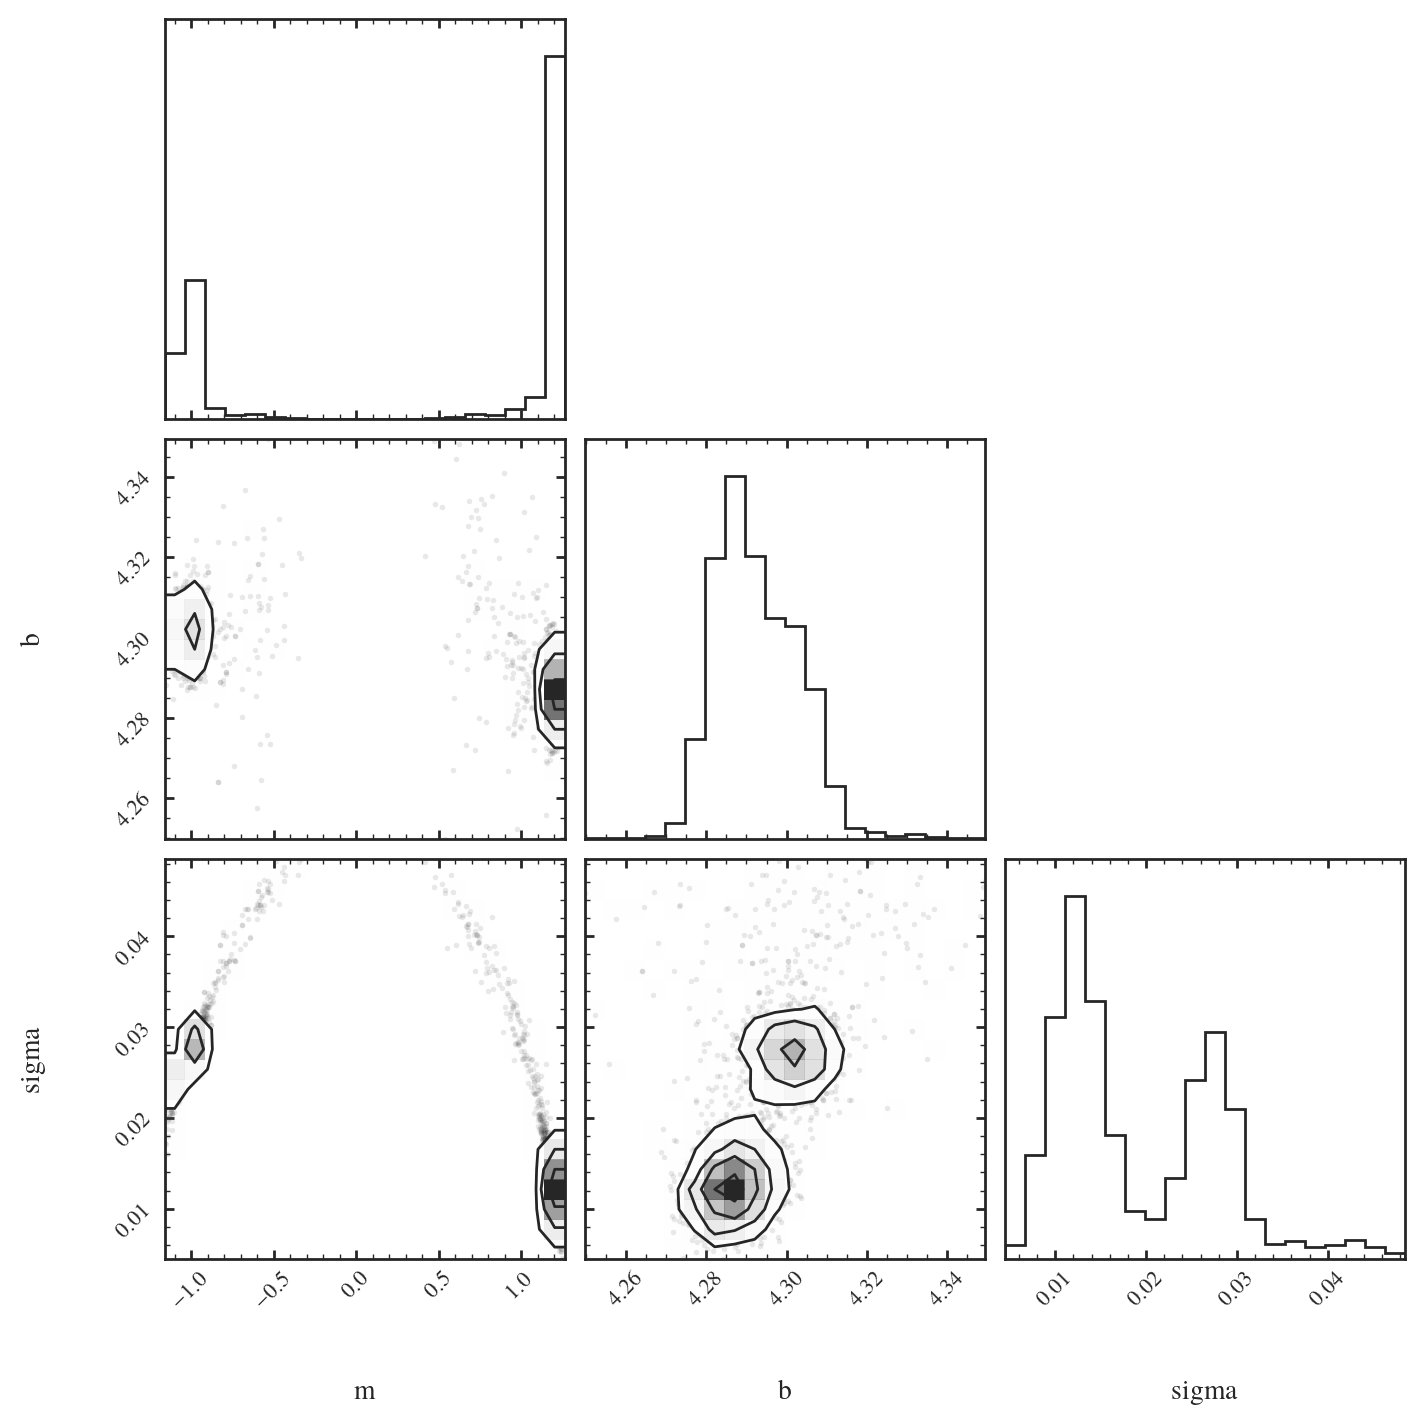

In [95]:

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, subgiants.MG_H, subgiants.C_MG, subgiants.MG_H_ERR, subgiants.C_MG_ERR))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

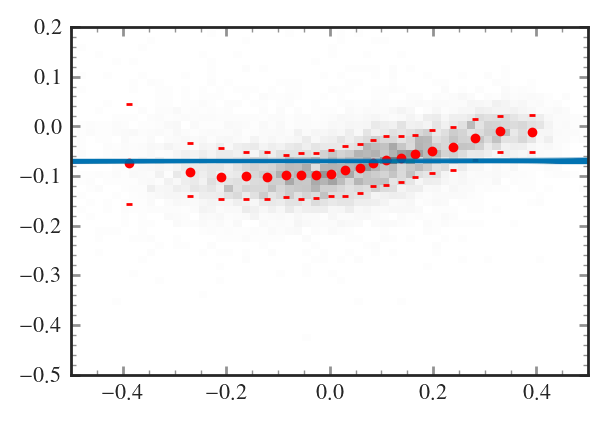

In [96]:
plt.hist2d(subgiants.MG_H, subgiants.C_MG, 200, cmap="Greys", alpha=0.5);

for i in range(0, len(samples), 1):
    theta = samples[i, :]
    x = np.linspace(-0.5, 0.5, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.1, color=arya.COLORS[0], alpha=0.2, )
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.2)
arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", color="r", errorbar="pi")


# Classical analysis

(-0.3, 0.1)

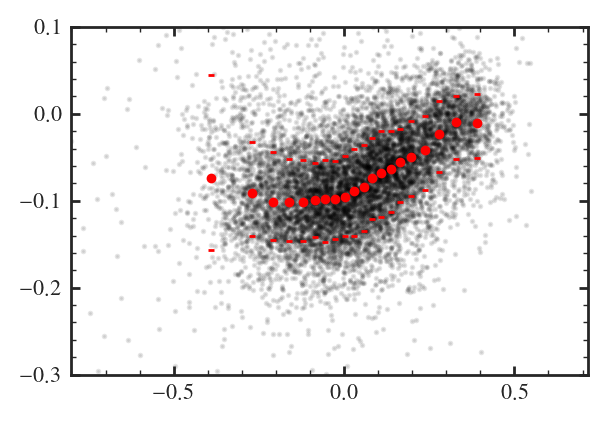

In [85]:
arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", color="r", errorbar="pi")
#arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="mean", color="r", errorbar=None)

plt.scatter(subgiants.MG_H, subgiants.C_MG, s=1, color="k", alpha=0.1, zorder=-1)
plt.xlim(-0.8)
plt.ylim(-0.3, 0.1)

Text(0, 0.5, '[c/o]')

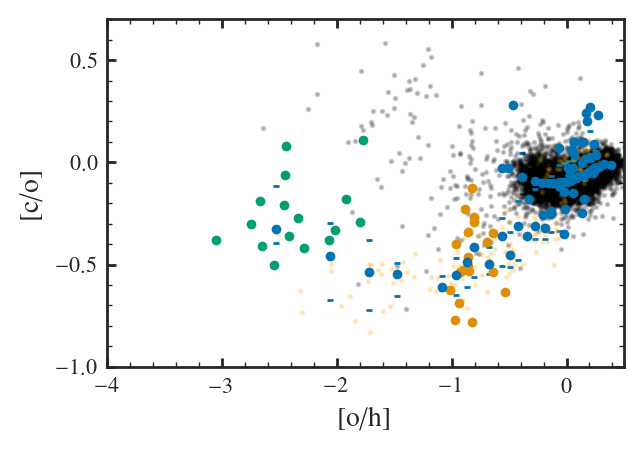

In [86]:
df_s = arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", errorbar="pi", zorder=3)
plt.scatter(subgiants.MG_H, subgiants["C_MG"], s=1, color="k", alpha=0.2)

df_a = arya.medianplot(all_abundances, x="MG_H", y="C_MG", binsize=10, stat="median", errorbar="pi", zorder=3)
plt.scatter(df_stars.MG_H, df_stars["C_MG"], s=1, color="orange", alpha=0.2)

MoverH = df_s.data.x
c_o = df_s.data.y
c_o_err = (df_s.data.y_h - df_s.data.y_l)/(df_s.data.counts)**0.5

MoverH_a = df_a.data.x
c_o_a = df_a.data.y
c_o_err_a = (df_a.data.y_h - df_a.data.y_l)/(df_a.data.counts)**0.5
plt.scatter(RL_all.MG_H, RL_all.C_MG)
plt.scatter(dwarf_all.MG_H, dwarf_all.C_MG)
plt.scatter(DLA_all.MG_H, DLA_all.C_MG)




plt.xlim(-4, 0.5)
plt.ylim(-1, 0.7)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

In [87]:
def y_mod(x, a, b):
    return a*Z_SUN*np.log10(x/Z_SUN) + b



In [101]:
def co_to_yc(c_o):
    return y_mg_cc * gcem.brak_to_abund(c_o, "C", "Mg")

y_mg_cc = vice.yields.ccsne.settings["mg"]
y_o_cc = vice.yields.ccsne.settings["o"]
y_c_cc = vice.yields.ccsne.settings["c"]


[0.06376629 0.00274712]
[7.21199192e-03 2.22502916e-05]


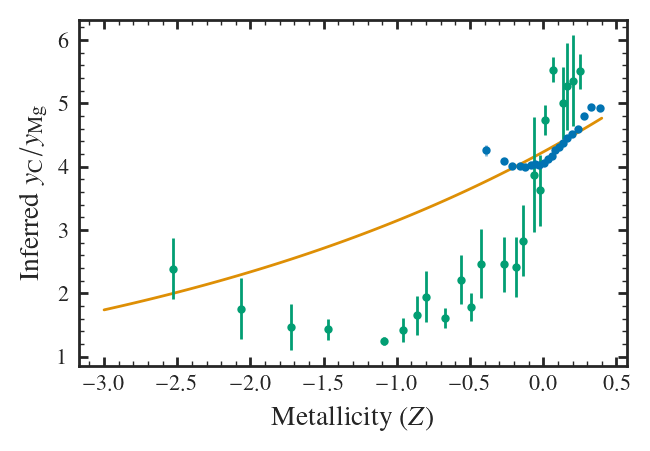

In [148]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = np.float64(y_c * np.log(10) * c_o_err)

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(MoverH, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

popt, covt = curve_fit(y_mod, Z, y_c, sigma=y_c_err, p0=(0.05, 0.1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

x = np.linspace(-3, 0.4, 100)
Z = MH_to_Z(x)
c_mg_pred = model(x, np.mean(samples, axis=0))
plt.plot(x, gcem.brak_to_abund(c_mg_pred, "c", "mg"))

#plt.plot(Z, 10**-0.02*y_mod(Z, 0.0237, 0.00271)/y_mg_cc, lw=2, label="model")


plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")


y_c_a = y_o_cc*gcem.brak_to_abund(c_o_a, "C", "O")
y_err_a = y_c_a * np.log(10) * c_o_err_a

a,b,c = plt.errorbar((MoverH_a), y_c_a/y_mg_cc, y_err_a/y_mg_cc, fmt="o", capsize=0, ms=2)


plt.tight_layout()
plt.savefig("figures/analytic.pdf")



In [164]:
def plot_eq(**kwargs):
    surp.yields.set_yields(**kwargs)

    M_H = np.linspace(-3, 0.45,300)
    Zs = gcem.MH_to_Z(M_H)
    y_mg = vice.yields.ccsne.settings["mg"]
    ys = [surp.yields.calc_y(Z) for Z in Zs]
    ymg = [surp.yields.calc_y(Z, "mg") for Z in Zs]


    co = gcem.abund_to_brak(np.array(ys) / ymg, "C", "MG")
    oh = gcem.abund_to_brak(ymg, "C", "MG")
    
    plt.plot(M_H, co, label="equilibrium")


In [ ]:
plot_eq()
plot_eq(c_agb_alpha=0)
plot_eq(c_cc_y0=0, c_agb_alpha=1.5)
a,b,c = plt.errorbar(MoverH, c_o, c_o_err, fmt="o", capsize=0, ms=2)
a,b,c = plt.errorbar(MoverH_a, c_o_a, c_o_err_a, fmt="o", capsize=0, ms=2)


In [93]:
def y_mod2(x, a, b, c):
    return a + b*(x - Z_SUN)+ c*(x-Z_SUN)**2



[0.00270433 0.02008416 0.24711708]
[1.56322655e-05 2.90767737e-03 1.73783064e-01]


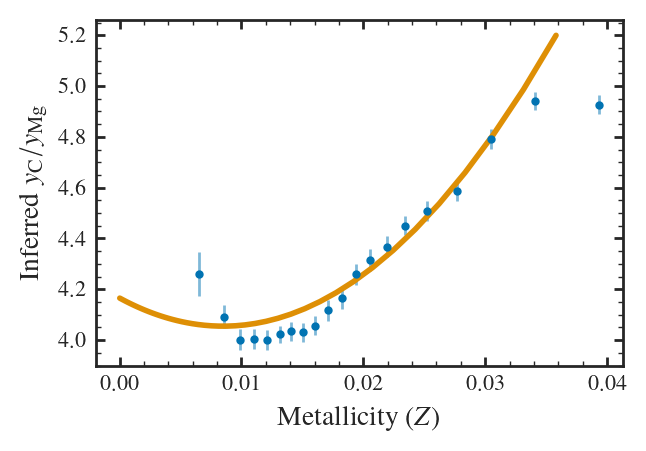

In [94]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = np.float64(y_c * np.log(10) * c_o_err)

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

chop = 3
popt, covt = curve_fit(y_mod2, Z, y_c, sigma=y_c_err, p0=(0.003, 0.1, 1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)
#plt.plot(Z, 10**-0.04*y_mod2(Z, 2.77e-3, 0.025, 1.15)/y_mg_cc, lw=2, label="model")
plt.plot(Z, y_mod2(Z, 0.0027, 0.015, 1)/y_mg_cc, lw=2, label="model")

#plt.plot(Z, surp.yields.y_c_total(Z)/y_mg_cc*10**-0.02, lw=2)

plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.tight_layout()
plt.savefig("figures/analytic.pdf")

TypeError: 'int' object is not callable

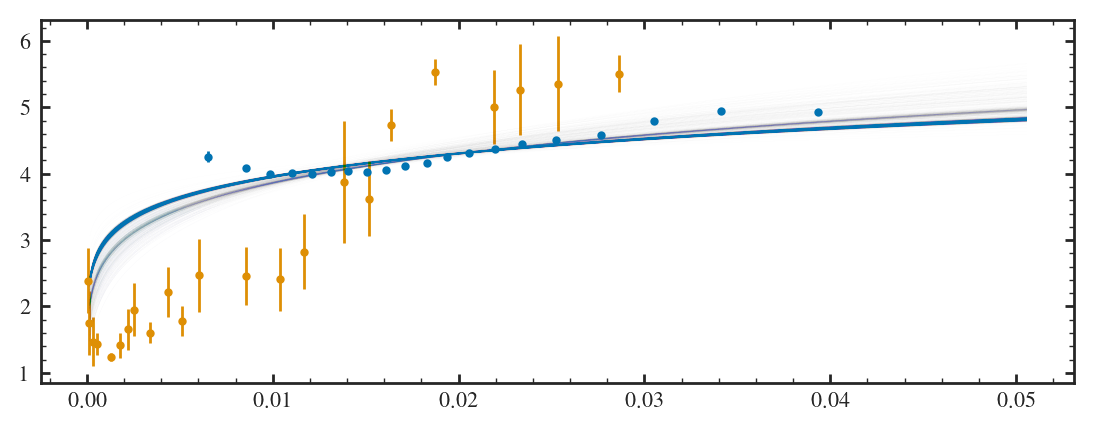

In [122]:
plt.figure(figsize=(20/3, 10/3/np.sqrt(2)))
# parameters
Z = MH_to_Z(MoverH)


y_c = co_to_yc(c_o)
y_c_err = y_c * np.log(10) * c_o_err

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)

x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)


y_c_a = y_o_cc*gcem.brak_to_abund(c_o_a, "C", "O")
y_err_a = y_c_a * np.log(10) * c_o_err_a

a,b,c = plt.errorbar(MH_to_Z(MoverH_a), y_c_a/y_mg_cc, y_err_a/y_mg_cc, fmt="o", capsize=0, ms=2)


mass_yields = []
for z in Z:
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c")
    m_c, times = vice.single_stellar_population("c", Z=z)
    mass_yields.append(m_c[-1]/1e6/y_mg_cc)

for i in range(0, len(samples), 1):
    theta = samples[i, :]
    x = np.linspace(-2, 0.5, 1000)
    y = model(x, theta)
    plt.plot(MH_to_Z(x), 5*10**y, lw=0.1, color=arya.COLORS[0], alpha=0.02, )
    
def y_mod3(Z):
    return 0.5*(gcem.Z_to_MH(Z) + 1.5)**2 + 26*(Z-gcem.Z_SUN)+ 1.75

#surp.yields.set_yields(f_agb=0.2)

y_mod3 = lambda Z: vice.yields.ccsne.settings["c"](Z) /y_mg_cc
mass_yields = np.array(mass_yields)
y_tot = y_mod3(Z) + mass_yields

plt.plot(Z, y_tot*10**-0.02, label="total")
# plt.plot(Z,  mass_yields, lw=2, label="model")

#plt.plot(Z, y_mod3(Z))


plt.xlabel(r"Metallicity ($Z$)")
plt.xlim(2e-5, 0.05)
plt.ylim(0, 8)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.xscale("log")
#plt.xscale("asinh", linear_width=0.001)
#plt.gca().xaxis.set_minor_locator(mpl.ticker.AsinhLocator(0.0001, subs=(2,4,6,8)))
#plt.xticks([0, 1e-4,1e-3, 1e-2])


plt.tight_layout()